In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [67]:
def prepare_data(grocery, product_name):
    
    product_df = grocery[grocery['product_name'] == product_name]
    
    product_df.drop(columns=['product_name', 'category', 'price', 'product_id', 'sales_time', 'buyer_gender'], inplace=True)
    
    product_df['holiday'] = product_df['holiday'].astype(int)
    product_df['day_of_week'] = product_df['sales_date'].dt.dayofweek
    
    group_columns = ['sales_date', 'day_of_week', 'holiday', 'month', 'day_of_year']
    product_df = product_df.groupby(group_columns).agg({
        'sales': 'sum',
        'total_revenue': 'sum'
    }).reset_index()
    
    product_df.set_index('sales_date', inplace=True)
    
    return product_df

In [68]:
def forecast_sales(product_df, train_cutoff='2023-08-31'):
    
    train = product_df.loc[product_df.index < train_cutoff]
    test = product_df.loc[product_df.index >= train_cutoff]

    X = ['day_of_week', 'holiday', 'month', 'day_of_year']
    y = 'sales'

    X_train = train[X]
    X_test = test[X]
    y_train = train[y]
    y_test = test[y]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    fi = pd.DataFrame(data=reg.feature_importances_,
                      index=reg.feature_names_in_,
                      columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    
    test['prediction'] = reg.predict(X_test)
    
    product_df = product_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

    ax = product_df[['sales']].plot(figsize=(15, 5))
    product_df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('Raw Data and Predictions')
    
    score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
    print(f'RMSE Score on Test set: {score:0.2f}')
    
    return product_df, reg

In [69]:
def forecast_future_sales(model, future_dates):
    future_df = pd.DataFrame(index=future_dates)
    future_df['day_of_week'] = future_df.index.dayofweek
    future_df['holiday'] = 0
    future_df['month'] = future_df.index.month
    future_df['day_of_year'] = future_df.index.dayofyear
    future_df['forecast'] = model.predict(future_df)
    return future_df

Select one of the following items to predict sales
['Milk packet' 'Bread package' 'Butter' 'Jam jar' 'Eggs']


Enter Product Name:  Butter


[0]	validation_0-rmse:115.48524	validation_1-rmse:117.74387
[100]	validation_0-rmse:56.87194	validation_1-rmse:65.07357
[200]	validation_0-rmse:41.47750	validation_1-rmse:53.29012
[300]	validation_0-rmse:37.66164	validation_1-rmse:50.86465


C:\Users\PMLS\AppData\Local\Temp\ipykernel_632\1736199734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df.drop(columns=['product_name', 'category', 'price', 'product_id', 'sales_time', 'buyer_gender'], inplace=True)
C:\Users\PMLS\AppData\Local\Temp\ipykernel_632\1736199734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['holiday'] = product_df['holiday'].astype(int)
C:\Users\PMLS\AppData\Local\Temp\ipykernel_632\1736199734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

[400]	validation_0-rmse:36.10041	validation_1-rmse:50.45094
[500]	validation_0-rmse:35.06480	validation_1-rmse:50.07168
[600]	validation_0-rmse:34.35627	validation_1-rmse:49.93531
[634]	validation_0-rmse:34.19041	validation_1-rmse:49.98373
RMSE Score on Test set: 49.93


C:\Users\PMLS\AppData\Local\Temp\ipykernel_632\1393423023.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


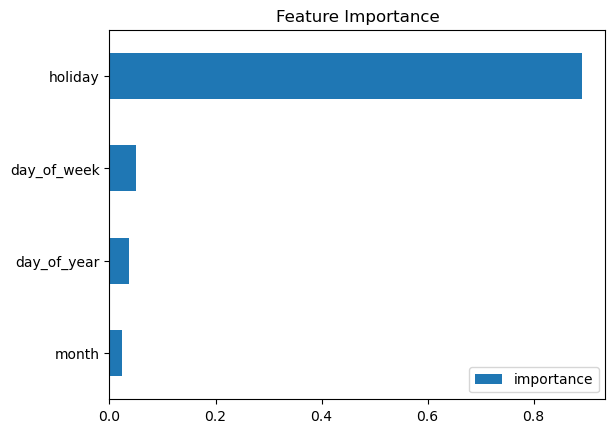

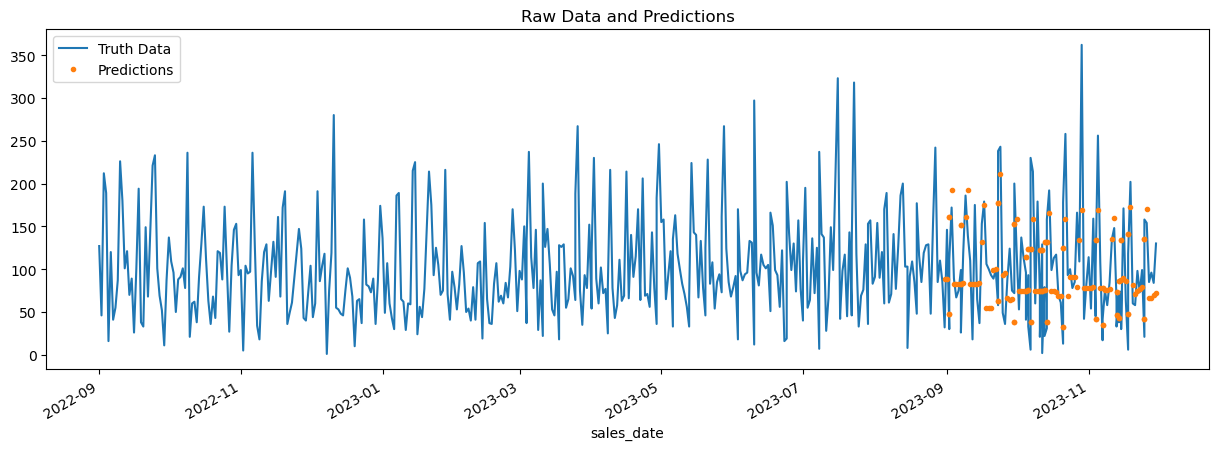

In [70]:
grocery = pd.read_csv('Grocery_sales_dataset.csv')
grocery.rename(columns={'number_of_items_sold':'sales'}, inplace=True)
grocery['sales_date'] = pd.to_datetime(grocery['sales_date'])
grocery['month'] = grocery['sales_date'].dt.month
grocery['day_of_year'] = grocery['sales_date'].dt.dayofyear
print('Select one of the following items to predict sales')
print(grocery['product_name'].unique())
pro_name = input("Enter Product Name: ")
pro_df = prepare_data(grocery, pro_name)
pro_df, pro_reg = forecast_sales(pro_df)

In [71]:
future_dates = pd.date_range(start='2023-12-01', periods=30, freq='D')
future_sales = forecast_future_sales(bread_reg, future_dates)

<Axes: title={'center': 'Future Sales Forecast'}>

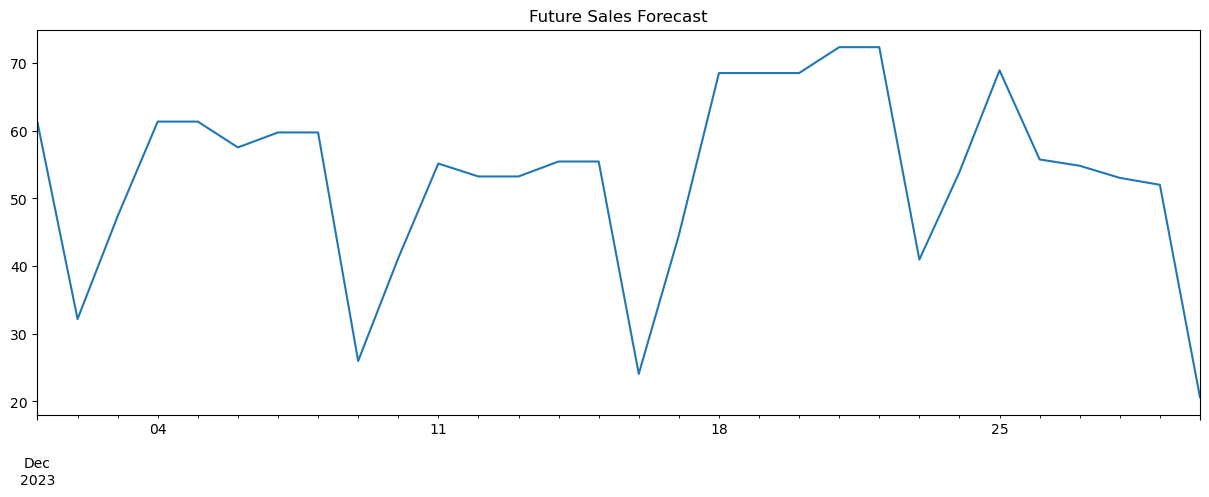

In [72]:
future_sales['forecast'].plot(figsize=(15, 5), title='Future Sales Forecast')